In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from pathlib import Path

In [2]:
root_path = "/media/Datacenter_storage/Ji/brain_mri_valdo_mayo/mayo_yolo_t2s_only_rotated_GAN"
task = "images/test"

In [3]:
uid_set = set()
for file in os.listdir(os.path.join(root_path, task)):
    uid = file.split('_')[0]
    if uid not in uid_set:
        uid_set.add(uid)
print(uid_set)
print(len(uid_set))

{'10745491', '5811558', '7995053', '6780692', '5075599', '5938862', '4953391', '4806209', '7800567', '5957595', '5835693', '5808373', '10813100', '12503291', '6917326', '4945862', '5768637', '4990472', '5820695', '5929128', '7556853', '5809343', '10791512', '5854417', '4836682', '5773274', '6991743', '5881689', '5995155', '10765931', '5967524', '10734610', '5995152', '7874875', '6920455', '6992446', '7556823', '5778358', '5827390', '5931046', '6940170', '6926040', '7969346', '4869073', '12151060', '10857463', '5790129', '5808368', '7623266', '6990786', '7867995', '7797334', '5785841', '6780698', '5834851', '4906587', '7967074', '6769837', '5771968', '4817373', '5886223', '7833902', '5995158', '4981854', '4867541', '4910831', '10895233', '5987394', '5878129', '4798157', '6807682', '4881849', '5877327', '4867588', '5834809', '5896685', '10869254', '7678804', '5778204', '6782776', '6934580', '10863578', '12595866', '10757098', '7517769', '4796915', '7787993', '7503261', '12873856', '10906

### Dataset Visualization

In [4]:
# Image path
# /images/train/sub-101_slice_009.png
img_num = "12235430"
slice_num = "16"

### Fixed Size Ground Truth Box

In [5]:
def extract_patch(channel, center_x, center_y, patch_size):
    """
    Extract a fixed-size patch centered on the given coordinates
    """
    height, width = channel.shape
    half_size = patch_size // 2
    
    # Calculate patch boundaries
    x_min = int(center_x - half_size)
    y_min = int(center_y - half_size)
    x_max = int(center_x + half_size)
    y_max = int(center_y + half_size)
    
    # Handle edge cases
    if x_min < 0:
        x_max -= x_min  # Shift patch right
        x_min = 0
    if y_min < 0:
        y_max -= y_min  # Shift patch down
        y_min = 0
    if x_max > width:
        x_min -= (x_max - width)  # Shift patch left
        x_max = width
    if y_max > height:
        y_min -= (y_max - height)  # Shift patch up
        y_max = height
    
    return channel[y_min:y_max, x_min:x_max]

def plot_yolo_boxes_with_channel_patches(image_path, bboxes):
    """
    Plot original channels and their 16x16 patches without overlap
    """
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"The image file does not exist: {image_path}")
    
    try:
        image = Image.open(image_path)
        image = np.array(image)
    except Exception as e:
        raise IOError(f"Error reading the image: {e}")
    
    if len(image.shape) == 2:
        image = np.stack((image,) * 3, axis=-1)
    height, width = image.shape[:2]
    n_boxes = len(bboxes)
    
    if n_boxes == 0:
        print("No bounding boxes found in the image.")
        return
        
    # Create figure with original image row plus one row per bbox
    fig = plt.figure(figsize=(15, 4 * (n_boxes + 1)))

    # Create GridSpec with n_boxes + 1 rows (1 for original images, rest for patches)
    gs = plt.GridSpec(n_boxes + 1, 3, figure=fig, hspace=0.4)

    # Channel names
    channel_names = ['T2S']

    # Plot each channel
    for channel_idx, channel_name in enumerate(channel_names):
        # Extract channel
        channel = image[:, :, channel_idx]

        # Plot full image in top row
        ax = fig.add_subplot(gs[0, channel_idx])
        # im = ax.imshow(channel, cmap='gray', vmin=0, vmax=255)
        im = ax.imshow(channel, cmap='gray')
        ax.set_title(f'{channel_name}')
        plt.colorbar(im, ax=ax, label='Intensity')
        
        # Draw all bounding boxes on original image
        for bbox in bboxes:
            class_id, x_center, y_center, gt_width, gt_height = bbox
            center_x = int(x_center * width)
            center_y = int(y_center * height)
            
            patch_size = gt_width * width
            
            # Draw fixed-size box
            half_size = patch_size // 2
            x_min = center_x - half_size
            y_min = center_y - half_size
            
            rect = plt.Rectangle((x_min, y_min), patch_size, patch_size,
                               linewidth=0.3, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
        
        # Plot patches
        for box_idx, bbox in enumerate(bboxes):
            _, x_center, y_center, gt_width, gt_height = bbox
            center_x = int(x_center * width)
            center_y = int(y_center * height)
            
            # Extract patch
            patch_size = gt_width * width
            patch = extract_patch(channel, center_x, center_y, patch_size)
            # Create subplot for patch in its own row
            ax_patch = fig.add_subplot(gs[box_idx + 1, channel_idx])
            # im_patch = ax_patch.imshow(patch, cmap='gray', vmin=0, vmax=255)
            im_patch = ax_patch.imshow(patch, cmap='gray')
            ax_patch.set_title(f'{channel_name} Patch {box_idx + 1}')
            plt.colorbar(im_patch, ax=ax_patch, label='Intensity')
            ax_patch.axis('on')
    
    plt.tight_layout()
    plt.show()

def visualize_image_channels_and_patches(root_path, img_num, slice_num):
    label_path = f"{root_path}/labels/test/{img_num}_{slice_num}.txt"
    image_path = label_path.replace("labels", "images").replace("txt", "png")
    plot_original_image(image_path)
    try:
        with open(label_path, 'r') as txt_file:
            bboxes = [list(map(float, line.split())) for line in txt_file.readlines()]
        plot_yolo_boxes_with_channel_patches(image_path, bboxes)
        
    except Exception as e:
        print(f"An error occurred: {e}")
        try:
            with Image.open(image_path) as img:
                print(f"Image format: {img.format}")
                print(f"Image size: {img.size}")
                print(f"Image mode: {img.mode}")
        except Exception as e:
            print(f"Could not open the image for additional information: {e}")
            
def plot_original_image(img_path):    
    img = Image.open(img_path)
    img = np.array(img)
    plt.figure(figsize=(10, 10))
    plt.imshow(img[:,:], cmap='gray')
    plt.title('T2S Image')

<ipython-input-5-5beb78ce2bf8>:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


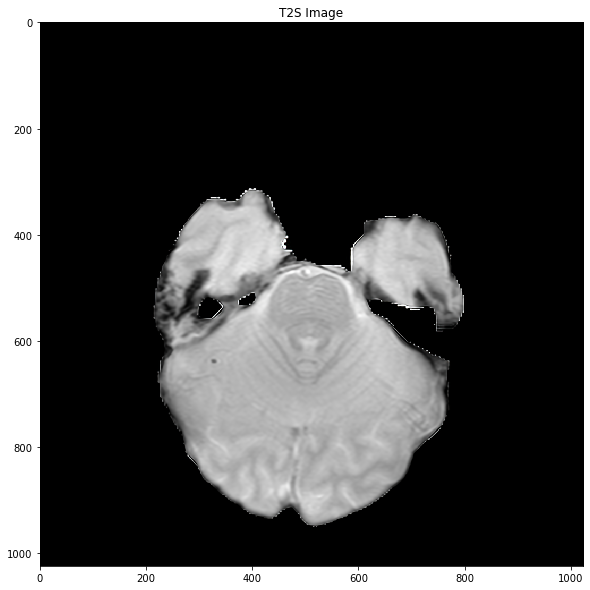

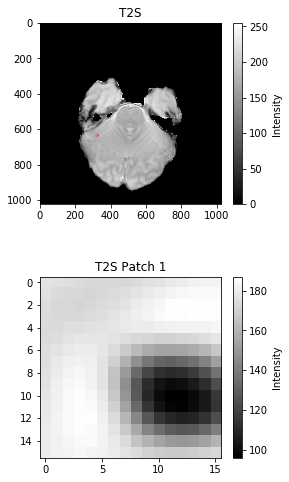

In [6]:
visualize_image_channels_and_patches(root_path, img_num, slice_num)

In [7]:
def find_nonempty_text_files(directory):
    nonempty_files = []
    dir_path = Path(directory)
    for txt_file in dir_path.glob("*.txt"):
        if txt_file.stat().st_size > 0:
            with open(txt_file, 'r') as f:
                content = f.read().strip()
                if content:  # Check if there's actual content after stripping whitespace
                    nonempty_files.append(txt_file.name)  
    return sorted(nonempty_files)  # Sort alphabetically

task = "test"
directory = f"{root_path}/labels/{task}"  # Replace with your folder path
nonempty_files = find_nonempty_text_files(directory)

count = 0
print(f"Found {len(nonempty_files)} non-empty text files:")
for filename in nonempty_files:
    count += 1
    print(f"- {filename}")
print(count)

Found 28 non-empty text files:
- 10745491_24.txt
- 10745491_28.txt
- 10745491_29.txt
- 10745491_30.txt
- 10745491_33.txt
- 10745491_34.txt
- 10745491_8.txt
- 12235430_16.txt
- 12235430_17.txt
- 4817777_29.txt
- 4817777_30.txt
- 4817777_31.txt
- 4906587_18.txt
- 4906587_19.txt
- 4918736_11.txt
- 4918736_12.txt
- 4918736_13.txt
- 4918736_24.txt
- 4918736_25.txt
- 4918736_26.txt
- 5808373_17.txt
- 5808373_18.txt
- 5929128_12.txt
- 5929128_21.txt
- 5929128_22.txt
- 5929128_25.txt
- 5929128_8.txt
- 6780698_27.txt
28
